## MSBA 6420 - HW4 - Q2 - Ravi Hasyagar

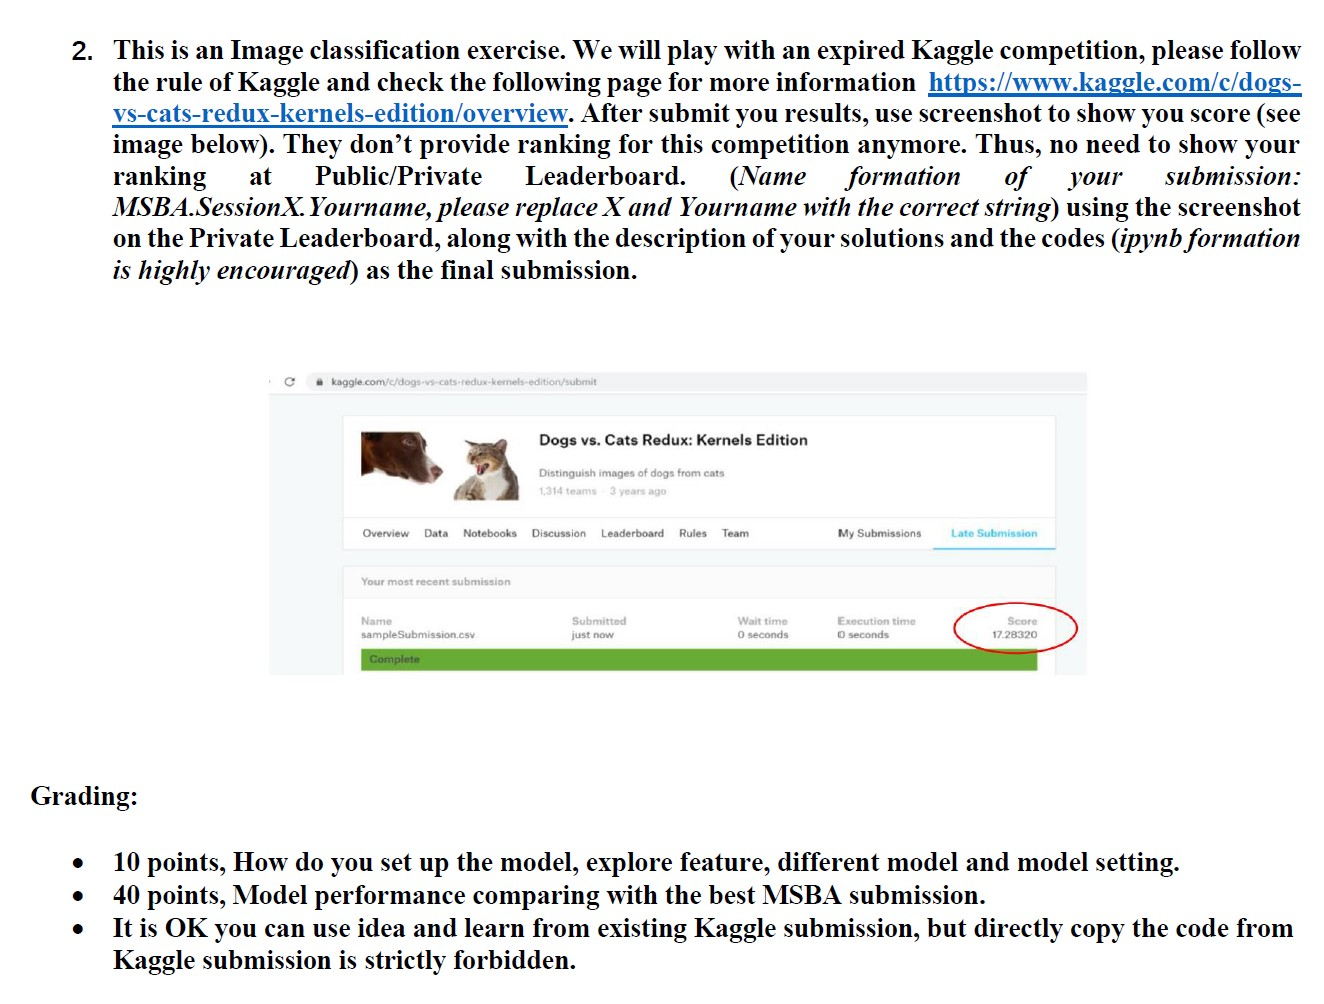

In [66]:
## ALL IMPORTS
from PIL import Image
resolutionX = 224
resolutionY = 224

import os

import numpy as np

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [67]:
train_dir = 'D:\\Academics\\UMN-MSBA\\Term 2\\MSBA 6420 - Predictive Analytics\\HW4\\train'
validation_dir = 'D:\\Academics\\UMN-MSBA\\Term 2\\MSBA 6420 - Predictive Analytics\\HW4\\test - Copy'
final_dir = 'D:\\Academics\\UMN-MSBA\\Term 2\\MSBA 6420 - Predictive Analytics\\HW4\\test'

In [68]:
checkpoint_path = 'D:\\Academics\\UMN-MSBA\\Term 2\\MSBA 6420 - Predictive Analytics\\HW2'
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=True,
                             verbose=1)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

## Image pre-processing

In [69]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rotation_range = 40, 
                                   width_shift_range = 0.20, 
                                   height_shift_range = 0.20, 
                                   shear_range = 0.20, 
                                   zoom_range = 0.1, 
                                   horizontal_flip = True,
                                   validation_split = 0.15)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator()

final_datagen = ImageDataGenerator()

In [70]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 10,
                                                    class_mode = 'binary', 
                                                    target_size = (resolutionX, resolutionY),
                                                    # subset="training",
                                                    shuffle = False)

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                         # batch_size = 1,
                                                        class_mode = 'binary', 
                                                        target_size = (resolutionX, resolutionY),
                                                        # subset="validation",
                                                        shuffle = False)

# Flow validation images in batches of 20 using test_datagen generator
final_generator = final_datagen.flow_from_directory(final_dir,
                                                    batch_size = 10,
                                                    class_mode = 'binary', 
                                                    target_size = (resolutionX, resolutionY),
                                                    shuffle = False)

Found 25000 images belonging to 2 classes.
Found 177 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [71]:
final_generator.filenames[12499]

'test\\12500.jpg'

## VGG16

In [1]:
## Extra Imports
from tensorflow.keras.applications.vgg16 import VGG16

import pandas as pd

In [ ]:
base_model = VGG16(input_shape = (resolutionX, resolutionY, 3),
                    include_top = False,
                    weights = 'imagenet')

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(base_model.input, x)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
checkpoint_path = 'D:\\Academics\\UMN-MSBA\\Term 2\\MSBA 6420 - Predictive Analytics\\HW2'
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=True,
                             verbose=1)

In [ ]:
vgghist = model.fit(train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = 100, 
                    epochs = 10, 
                    callbacks=[cp_callback])

In [ ]:
predictions = model.predict(final_generator)

In [ ]:
import pandas as pd
y_pred_df = pd.DataFrame(predictions, index = list(range(1, 12501)), columns = ['label'])
y_pred_df.index.name = 'id'

In [ ]:
y_pred_df.to_csv('submission_VGG16.csv')

## ResNet50

In [52]:
tf.keras.backend.clear_session()

In [53]:
from tensorflow.keras.applications import ResNet50

In [54]:
base_model = Sequential()
base_model = ResNet50(include_top=False, weights='imagenet', pooling='max')

In [55]:
for layer in base_model.layers:
    layer.trainable = False

In [56]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# # Add a fully connected layer with 512 hidden units and ReLU activation
# x = layers.Dense(512, activation='relu')(x)
# x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(base_model.input, x)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [57]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = 'D:\\Academics\\UMN-MSBA\\Term 2\\MSBA 6420 - Predictive Analytics\\HW2'
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=True,
                             verbose=1)

In [58]:
model.fit_generator(train_generator,
               validation_data = validation_generator,
               steps_per_epoch = 200, 
               epochs = 10,
               callbacks=[cp_callback, es_callback])

Epoch 1/10


C:\Users\ravih\AppData\Local\Temp/ipykernel_47968/45519545.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,


200/200 [==============================] - ETA: 0s - loss: 1.0435 - acc: 0.8285
Epoch 1: saving model to D:\Academics\UMN-MSBA\Term 2\MSBA 6420 - Predictive Analytics\HW2
200/200 [==============================] - 27s 125ms/step - loss: 1.0435 - acc: 0.8285 - val_loss: 0.5379 - val_acc: 0.8927
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 0.4192 - acc: 0.9230
Epoch 2: saving model to D:\Academics\UMN-MSBA\Term 2\MSBA 6420 - Predictive Analytics\HW2
200/200 [==============================] - 24s 119ms/step - loss: 0.4192 - acc: 0.9230 - val_loss: 0.2183 - val_acc: 0.9548
Epoch 3/10
200/200 [==============================] - ETA: 0s - loss: 0.4408 - acc: 0.9230
Epoch 3: saving model to D:\Academics\UMN-MSBA\Term 2\MSBA 6420 - Predictive Analytics\HW2
200/200 [==============================] - 24s 119ms/step - loss: 0.4408 - acc: 0.9230 - val_loss: 0.2361 - val_acc: 0.9661
Epoch 4/10
200/200 [==============================] - ETA: 0s - loss: 0.3671 - acc: 0.9365
Ep

In [64]:
predictions = model.predict_generator(final_generator)

C:\Users\ravih\AppData\Local\Temp/ipykernel_47968/2736159155.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(final_generator)


In [61]:
# y_pred = [round(i[1]) for i in predictions]
import pandas as pd
y_pred_df = pd.DataFrame( predictions, index = list(range(1, 12501)), columns = ['label'])
#y_pred_df['label'] = y_pred_df['label'].apply(lambda x: aim(x))
y_pred_df.index.name = 'id'

In [62]:
y_pred_df.to_csv('submission_ResNet50.csv')

## Xception

In [44]:
from tensorflow.keras.applications import Xception

In [45]:
base_model = Xception(weights = 'imagenet', include_top=True)

In [46]:
for layer in base_model.layers:
    layer.trainable = False

In [47]:
# x = layers.Dense(512, activation='relu')(base_model.output)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(base_model.output)

model = Model(base_model.input, x)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [48]:
history = model.fit(train_generator, 
                      validation_data = validation_generator, 
                      steps_per_epoch = 200, 
                      epochs = 50,
                      callbacks=[cp_callback, es_callback])

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.6915 - acc: 0.5345
Epoch 1: saving model to D:\Academics\UMN-MSBA\Term 2\MSBA 6420 - Predictive Analytics\HW2
200/200 [==============================] - 26s 120ms/step - loss: 0.6915 - acc: 0.5345 - val_loss: 0.6902 - val_acc: 0.5198
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.6907 - acc: 0.5540
Epoch 2: saving model to D:\Academics\UMN-MSBA\Term 2\MSBA 6420 - Predictive Analytics\HW2
200/200 [==============================] - 24s 119ms/step - loss: 0.6907 - acc: 0.5540 - val_loss: 0.6878 - val_acc: 0.6102
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.6882 - acc: 0.5780
Epoch 3: saving model to D:\Academics\UMN-MSBA\Term 2\MSBA 6420 - Predictive Analytics\HW2
200/200 [==============================] - 24s 119ms/step - loss: 0.6882 - acc: 0.5780 - val_loss: 0.6853 - val_acc: 0.6045
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.6888 - acc

In [13]:
predictions = model.predict(final_generator)

In [14]:
# y_pred = [round(i[1]) for i in predictions]
import pandas as pd
y_pred_df = pd.DataFrame( predictions, index = list(range(1, 12501)), columns = ['label'])
y_pred_df['label'] = y_pred_df['label'].apply(lambda x: 1 - x)
y_pred_df.index.name = 'id'

In [15]:
y_pred_df.to_csv('submission_Xception.csv')

## Inception

In [76]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [77]:
base_model = InceptionV3(input_shape = (resolutionX, resolutionY, 3), include_top = False, weights = 'imagenet')

In [78]:
for layer in model.layers:
    layer.trainable = False

In [79]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
model.fit(train_generator,
               validation_data = validation_generator,
               steps_per_epoch = 200, 
               epochs = 100,
               callbacks=[cp_callback, es_callback])

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 2.2499 - acc: 0.5295
Epoch 1: saving model to D:\Academics\UMN-MSBA\Term 2\MSBA 6420 - Predictive Analytics\HW2
200/200 [==============================] - 42s 142ms/step - loss: 2.2499 - acc: 0.5295 - val_loss: 0.6930 - val_acc: 0.5085
Epoch 2/100
149/200 [=====================>........] - ETA: 5s - loss: 0.6933 - acc: 0.5094

In [ ]:
predictions = model.predict(final_generator)
predictions = predictions.clip(min = 0.005, max = 0.995) 

In [50]:
# y_pred = [round(i[1]) for i in predictions]
import pandas as pd
y_pred_df = pd.DataFrame( predictions, index = list(range(1, 12501)), columns = ['label'])
# y_pred_df['label'] = y_pred_df['label'].apply(lambda x: aim(x))
y_pred_df.index.name = 'id'

In [51]:
y_pred_df.to_csv('submission_Inception.csv')